In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import copy
import time
import random
import mkl

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../src/')

from entropy import Entropy
from rand import Random
from single_policy import Single_policy
from fal import Fal
from decouple import Decouple
from falcon import Combined
from utils import *

pip install 'aif360[LawSchoolGPA]'


# Load fairness dataset from Folktables and AIF360 and define variabels

## 1. Dataset = TravelTime, Employ, Income, COMPAS
## 2. Fairness measure = DP, EO, ED, PP, EER
## 3. ML model = LogisticRegression, NeuralNetwork

In [3]:
mkl.set_num_threads(5) # set the number of threads

dataset_type = "TravelTime" # Employ, Income, COMPAS
target_fairness = "DP" # EO, ED, PP, EER
ml_method = "lr" # nn
num_round, num_examples = 400, 10 # 200, 1 for COMPAS

seed_arr =  [1, 2, 3]
PRINT_RESULT = True

test_acc, test_fairness = dict(), dict()
test_acc_avg, test_acc_std = dict(), dict()
test_fairness_avg, test_fairness_std = dict(), dict()
tradeoff_acc, tradeoff_fairness = dict(), dict()

In [4]:
data, label, z, group_names, train_data_num, test_data_num, un_data_num, val_data_num = load_dataset(dataset_type)

# Original result (without labeling)

In [5]:
method = "Original"

print("=========================")
print(f"method: {method}")

test_acc[method], test_fairness[method] = [], []
for seed in seed_arr:
    random.seed(seed)
    np.random.seed(seed)
    
    x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
    model = model_training(x_train, y_train, x_val, y_val, ml_method)

    test_acc[method].append(model.score(x_test, y_test))
    test_fairness[method].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
    
    if PRINT_RESULT:
        print(f"-------- Seed: {seed} --------")
        print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}")

method: Original
-------- Seed: 1 --------
Test Accuracy: 0.76216, Test DP Score: 0.19708
-------- Seed: 2 --------
Test Accuracy: 0.76579, Test DP Score: 0.19445
-------- Seed: 3 --------
Test Accuracy: 0.76579, Test DP Score: 0.17867


# Entropy

In [6]:
method = "Entropy"

print("=========================")
print(f"method: {method}")

test_acc[method] = [[] for _ in range(num_round+1)]
test_fairness[method] = [[] for _ in range(num_round+1)]
for seed in seed_arr:
    random.seed(seed)
    np.random.seed(seed)

    x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
    train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
    un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
    val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)

    start = time.time()
    ENTROPY = Entropy(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, ml_method)
    
    model = model_training(ENTROPY.train_data, ENTROPY.train_label, ENTROPY.val_data, ENTROPY.val_label, ml_method)
    
    test_acc[method][0].append(model.score(x_test, y_test))
    test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
    for i in range(num_round):
        model = ENTROPY.make_query(model, num_examples)

        test_acc[method][i+1].append(model.score(x_test, y_test))
        test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])

    elapsed_time = time.time() - start
    if PRINT_RESULT:
        print(f"-------- Seed: {seed} --------")
        print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: Entropy
-------- Seed: 1 --------
Test Accuracy: 0.77658, Test DP Score: 0.13046, Runtime (sec): 157.86811
-------- Seed: 2 --------
Test Accuracy: 0.77752, Test DP Score: 0.13351, Runtime (sec): 156.39468
-------- Seed: 3 --------
Test Accuracy: 0.77658, Test DP Score: 0.12294, Runtime (sec): 156.34739


# Random

In [7]:
method = "Random"

print("=========================")
print(f"method: {method}")
    
test_acc[method] = [[] for _ in range(num_round+1)]
test_fairness[method] = [[] for _ in range(num_round+1)]
for seed in seed_arr:
    random.seed(seed)
    np.random.seed(seed)

    x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
    train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
    un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
    val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)

    start = time.time()
    RANDOM = Random(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, ml_method)
    
    model = model_training(RANDOM.train_data, RANDOM.train_label, RANDOM.val_data, RANDOM.val_label, ml_method)
    
    test_acc[method][0].append(model.score(x_test, y_test))
    test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
    for i in range(num_round):
        model = RANDOM.make_query(num_examples)

        test_acc[method][i+1].append(model.score(x_test, y_test))
        test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])

    elapsed_time = time.time() - start
    if PRINT_RESULT:
        print(f"-------- Seed: {seed} --------")
        print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: Random
-------- Seed: 1 --------
Test Accuracy: 0.77262, Test DP Score: 0.18512, Runtime (sec): 110.24551
-------- Seed: 2 --------
Test Accuracy: 0.76890, Test DP Score: 0.16113, Runtime (sec): 109.66830
-------- Seed: 3 --------
Test Accuracy: 0.77303, Test DP Score: 0.17338, Runtime (sec): 109.97627


# Falcon

In [8]:
policy_set = ["r=0.7", "r=0.6", "r=0.5", "r=0.4", "r=0.3"]
falcon_methods = ["Falcon (1.0)", "Falcon (0.9)", "Falcon (0.8)", "Falcon (0.7)", "Falcon (0.6)", "Falcon (0.5)", 
               "Falcon (0.4)", "Falcon (0.3)", "Falcon (0.2)", "Falcon (0.1)", "Falcon (0.0)"]

for method in falcon_methods:
    print("=====================")
    print(method) 
    
    lambda_ = float(method.split("(")[1].split(")")[0])
    test_acc[method] = [[] for _ in range(num_round+1)]
    test_fairness[method] = [[] for _ in range(num_round+1)]
    for seed in seed_arr:
        random.seed(seed)
        np.random.seed(seed)
        
        x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
        train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
        un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
        val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)

        start = time.time()
        FALCON = Combined(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, policy_set, lambda_, target_fairness, ml_method)

        model = model_training(FALCON.train_data, FALCON.train_label, FALCON.val_data, FALCON.val_label, ml_method)
        _, target_groups = fairness_metrics(model, FALCON.val_data, FALCON.val_label, FALCON.val_z, target_fairness)

        test_acc[method][0].append(model.score(x_test, y_test))
        test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
        for i in range(num_round):
            model = FALCON.make_query(model, target_groups, num_examples)
            _, target_groups = fairness_metrics(model, FALCON.val_data, FALCON.val_label, FALCON.val_z, target_fairness)

            test_acc[method][i+1].append(model.score(x_test, y_test))
            test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
            
        elapsed_time = time.time() - start
        if PRINT_RESULT:  
            print(f"-------- Seed: {seed} --------")
            print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

Falcon (1.0)
-------- Seed: 1 --------
Test Accuracy: 0.65705, Test DP Score: 0.97578, Runtime (sec): 116.63959
-------- Seed: 2 --------
Test Accuracy: 0.64847, Test DP Score: 0.97952, Runtime (sec): 117.38132
-------- Seed: 3 --------
Test Accuracy: 0.65983, Test DP Score: 0.96498, Runtime (sec): 116.70699
Falcon (0.9)
-------- Seed: 1 --------
Test Accuracy: 0.67266, Test DP Score: 0.89858, Runtime (sec): 120.94776
-------- Seed: 2 --------
Test Accuracy: 0.66669, Test DP Score: 0.90659, Runtime (sec): 121.81608
-------- Seed: 3 --------
Test Accuracy: 0.68198, Test DP Score: 0.83221, Runtime (sec): 120.62742
Falcon (0.8)
-------- Seed: 1 --------
Test Accuracy: 0.69183, Test DP Score: 0.77328, Runtime (sec): 122.91229
-------- Seed: 2 --------
Test Accuracy: 0.70539, Test DP Score: 0.67420, Runtime (sec): 125.29751
-------- Seed: 3 --------
Test Accuracy: 0.71030, Test DP Score: 0.65866, Runtime (sec): 126.62233
Falcon (0.7)
-------- Seed: 1 --------
Test Accuracy: 0.71545, Test DP

# D-FA$^2$L (Fairness-Aware Active Learning for Decoupled Model, in IJCNN 2022)

In [9]:
decouple_methods = ["D-FA$^2$L-0.1", "D-FA$^2$L-0.2", "D-FA$^2$L-0.3", "D-FA$^2$L-0.4", "D-FA$^2$L-0.5", "D-FA$^2$L-0.6", 
                    "D-FA$^2$L-0.7", "D-FA$^2$L-0.8", "D-FA$^2$L-0.9"]

for method in decouple_methods:
    print("=========================")
    print(f"method: {method}")
    
    alpha = float(method.split("-")[-1])
    test_acc[method] = [[] for _ in range(num_round+1)]
    test_fairness[method] = [[] for _ in range(num_round+1)]
    for seed in seed_arr:
        random.seed(seed)
        np.random.seed(seed)
        
        x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
        train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
        un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
        val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)
        
        start = time.time()
        DECOUPLE = Decouple(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, alpha, ml_method)

        model = model_training(DECOUPLE.train_data, DECOUPLE.train_label, DECOUPLE.val_data, DECOUPLE.val_label, ml_method)
        
        test_acc[method][0].append(model.score(x_test, y_test))
        test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
        for i in range(num_round):
            model = DECOUPLE.make_query(num_examples)

            test_acc[method][i+1].append(model.score(x_test, y_test))
            test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
            
        elapsed_time = time.time() - start
        if PRINT_RESULT:  
            print(f"-------- Seed: {seed} --------")
            print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: D-FA$^2$L-0.1
-------- Seed: 1 --------
Test Accuracy: 0.76976, Test DP Score: 0.19443, Runtime (sec): 191.57764
-------- Seed: 2 --------
Test Accuracy: 0.77115, Test DP Score: 0.18394, Runtime (sec): 191.25163
-------- Seed: 3 --------
Test Accuracy: 0.76817, Test DP Score: 0.16851, Runtime (sec): 188.71525
method: D-FA$^2$L-0.2
-------- Seed: 1 --------
Test Accuracy: 0.76661, Test DP Score: 0.21717, Runtime (sec): 188.72947
-------- Seed: 2 --------
Test Accuracy: 0.76853, Test DP Score: 0.18643, Runtime (sec): 188.69795
-------- Seed: 3 --------
Test Accuracy: 0.76972, Test DP Score: 0.17563, Runtime (sec): 189.13676
method: D-FA$^2$L-0.3
-------- Seed: 1 --------
Test Accuracy: 0.76584, Test DP Score: 0.20367, Runtime (sec): 189.01605
-------- Seed: 2 --------
Test Accuracy: 0.77127, Test DP Score: 0.17665, Runtime (sec): 188.95297
-------- Seed: 3 --------
Test Accuracy: 0.76935, Test DP Score: 0.17882, Runtime (sec): 190.08212
method: D-FA$^2$L-0.4
-------- Seed: 1 ----

# FAL (Fair active learning, in Expert Systems with Applications 2022)

In [10]:
fal_methods = ["FAL-2", "FAL-4", "FAL-16", "FAL-32", "FAL-64"]

for method in fal_methods:
    print("=========================")
    print(f"method: {method}")
    
    topk = int(method.split("-")[1])
    test_acc[method] = [[] for _ in range(num_round+1)]
    test_fairness[method] = [[] for _ in range(num_round+1)]
    for seed in seed_arr:
        random.seed(seed)
        np.random.seed(seed)
        
        x_train, y_train, z_train, x_test, y_test, z_test, x_un, y_un, z_un, x_val, y_val, z_val = generate_dataset(data, label, z, train_data_num, test_data_num, un_data_num, val_data_num, seed)
        train_data, train_label, train_z = copy.deepcopy(x_train), copy.deepcopy(y_train), copy.deepcopy(z_train)
        un_data, un_label, un_z = copy.deepcopy(x_un), copy.deepcopy(y_un), copy.deepcopy(z_un)
        val_data, val_label, val_z = copy.deepcopy(x_val), copy.deepcopy(y_val), copy.deepcopy(z_val)
        
        start = time.time()
        FAL = Fal(train_data, train_label, train_z, un_data, un_label, un_z, val_data, val_label, val_z, topk, target_fairness, ml_method)

        model = model_training(FAL.train_data, FAL.train_label, FAL.val_data, FAL.val_label, ml_method)
        
        test_acc[method][0].append(model.score(x_test, y_test))
        test_fairness[method][0].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
        for i in range(num_round):
            model = FAL.make_query(model, num_examples)

            test_acc[method][i+1].append(model.score(x_test, y_test))
            test_fairness[method][i+1].append(fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0])
            
        elapsed_time = time.time() - start
        if PRINT_RESULT:  
            print(f"-------- Seed: {seed} --------")
            print(f"Test Accuracy: {model.score(x_test, y_test):.5f}, Test {target_fairness} Score: {fairness_metrics(model, x_test, y_test, z_test, target_fairness)[0]:.5f}, Runtime (sec): {elapsed_time:.5f}")      

method: FAL-2
-------- Seed: 1 --------
Test Accuracy: 0.77049, Test DP Score: 0.16385, Runtime (sec): 245.56701
-------- Seed: 2 --------
Test Accuracy: 0.77213, Test DP Score: 0.13446, Runtime (sec): 245.55290
-------- Seed: 3 --------
Test Accuracy: 0.76886, Test DP Score: 0.15025, Runtime (sec): 245.24799
method: FAL-4
-------- Seed: 1 --------
Test Accuracy: 0.77515, Test DP Score: 0.14590, Runtime (sec): 425.79941
-------- Seed: 2 --------
Test Accuracy: 0.77487, Test DP Score: 0.14153, Runtime (sec): 423.14435
-------- Seed: 3 --------
Test Accuracy: 0.77360, Test DP Score: 0.11288, Runtime (sec): 426.50693
method: FAL-16
-------- Seed: 1 --------
Test Accuracy: 0.77687, Test DP Score: 0.13659, Runtime (sec): 1824.66675
-------- Seed: 2 --------
Test Accuracy: 0.77536, Test DP Score: 0.13796, Runtime (sec): 1861.52914
-------- Seed: 3 --------
Test Accuracy: 0.77540, Test DP Score: 0.12123, Runtime (sec): 1860.40063
method: FAL-32
-------- Seed: 1 --------
Test Accuracy: 0.77626

# Accuracy-fairness trade-offs

In [12]:
all_methods = ["Original", "Entropy", "Random"] + falcon_methods + decouple_methods + fal_methods
for method in all_methods:
    test_acc_avg[method], test_acc_std[method] = [], []
    test_fairness_avg[method], test_fairness_std[method] = [], []

    for i in range(len(test_acc[method])):
        test_acc_avg[method].append(np.average(test_acc[method][i]))
        test_acc_std[method].append(np.std(test_acc[method][i])/2)

        test_fairness_avg[method].append(np.average(test_fairness[method][i]))
        test_fairness_std[method].append(np.std(test_fairness[method][i])/2)

for method in all_methods:
    if method[:6] == "Falcon":
        if method[:6] not in tradeoff_acc:
            tradeoff_acc["Falcon"] = [test_acc_avg[method][-1]]
            tradeoff_fairness["Falcon"] = [test_fairness_avg[method][-1]]
        else:
            tradeoff_acc["Falcon"].append(test_acc_avg[method][-1])
            tradeoff_fairness["Falcon"].append(test_fairness_avg[method][-1])
    elif method[:4] == "D-FA":
        if method[:9] not in tradeoff_acc:
            tradeoff_acc["D-FA$^2$L"] = [test_acc_avg[method][-1]]
            tradeoff_fairness["D-FA$^2$L"] = [test_fairness_avg[method][-1]]
        else:
            tradeoff_acc["D-FA$^2$L"].append(test_acc_avg[method][-1])
            tradeoff_fairness["D-FA$^2$L"].append(test_fairness_avg[method][-1])
    elif method[:3] == "FAL":
        if method[:3] not in tradeoff_acc:
            tradeoff_acc["FAL"] = [test_acc_avg[method][-1]]
            tradeoff_fairness["FAL"] = [test_fairness_avg[method][-1]]
        else:
            tradeoff_acc["FAL"].append(test_acc_avg[method][-1])
            tradeoff_fairness["FAL"].append(test_fairness_avg[method][-1])
    else:
        tradeoff_acc[method] = [test_acc_avg[method][-1]]
        tradeoff_fairness[method] = [test_fairness_avg[method][-1]]

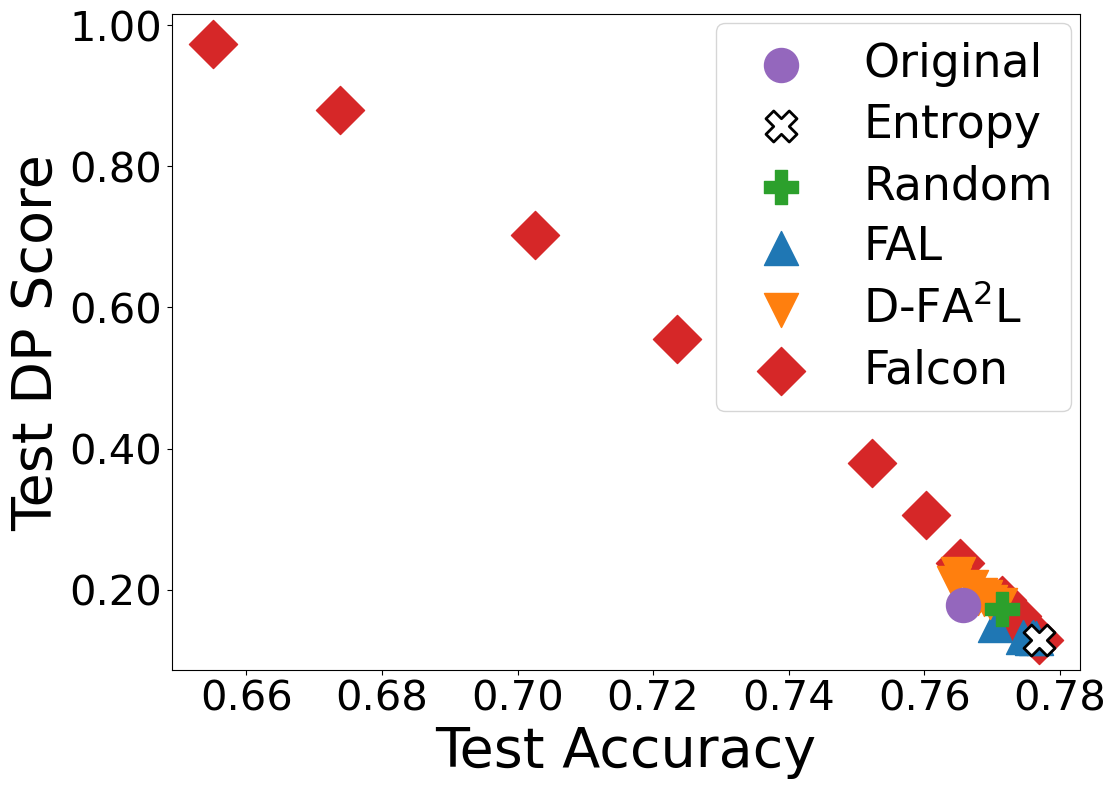

In [13]:
methods = ["Falcon", "FAL", "D-FA$^2$L", "Random", "Entropy", "Original"]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#2ca02c', '#9467bd']
shapes = ["D", "^", "v", "P", "X", "o"]

marker_size = 600

fig, ax = plt.subplots(figsize=(11, 8))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

for i in range(len(methods)):
    if methods[i] == "Entropy":
        plt.scatter(tradeoff_acc[methods[i]], np.array(tradeoff_fairness[methods[i]]), label=methods[i], s=marker_size-100, marker=shapes[i], edgecolors="black", linewidth=2, color="white")
    else:
        plt.scatter(tradeoff_acc[methods[i]], np.array(tradeoff_fairness[methods[i]]), label=methods[i], s=marker_size, marker=shapes[i], color = colors[i]) 
        

plt.tick_params(labelsize=30)
plt.xlabel("Test Accuracy", fontsize=40)
plt.ylabel(f"Test {target_fairness} Score", fontsize=40)

handles, labels = plt.gca().get_legend_handles_labels()
order = [5,4,3,1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], prop={'size':33}, borderaxespad = 0.2, labelspacing=0.35)

plt.tight_layout()
plt.show()